In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

In [2]:
# define classes and data structures for code formatting
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [3]:
# define the non-linear motion and the observation model
def motion_model(state, dt):
    g = 9.8  # gravity
    return np.array([
        state[0] + state[1] * dt,
        state[1] - g * np.sin(state[0]) * dt
    ])

def observation_model(state):
    return np.array([np.sin(state[0])])

In [4]:
# generate sigma points for UKF implementation
def sigma_points(X: Gaussian, alpha: float, kappa: float):
    n = X.mean.shape[0]
    lambda_ = alpha**2 * (n + kappa) - n

    try:
        L = np.linalg.cholesky((n + lambda_) * X.cov)
    except np.linalg.LinAlgError:
        # Add small regularization if cholesky decomposition fails
        L = np.linalg.cholesky((n + lambda_) * X.cov + 1e-8 * np.eye(n))

    sigma_pts = [X.mean]
    for i in range(n):
        sigma_pts.append(X.mean + L[i])
        sigma_pts.append(X.mean - L[i])

    return np.array(sigma_pts)

In [5]:
# unscented kalman filter main loop
def unscented_kalman_filter(data: Observations, X: Gaussian, xi: Gaussian, eta: Gaussian,
                            alpha: float, beta: float, kappa: float) -> KFTracker:

    num_steps = data.times.shape[0]
    d = X.mean.shape[0]
    dt = data.times[1] - data.times[0]

    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)

    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    Xnext = X
    on_obs = 0

    for k in range(1, num_steps):
        # Prediction step

        sigma_pts = sigma_points(Xnext, alpha, kappa)
        n = sigma_pts.shape[0]

        # Propagate sigma points
        propagated_pts = np.array([motion_model(pt, dt) for pt in sigma_pts])

        # Calculate weights
        lambda_ = alpha**2 * (d + kappa) - d
        weights_m = np.full(n, 1 / (2 * (d + lambda_)))
        weights_m[0] = lambda_ / (d + lambda_)
        weights_c = weights_m.copy()
        weights_c[0] += (1 - alpha**2 + beta)

        # Predict mean and covariance
        pred_mean = np.sum(weights_m[:, np.newaxis] * propagated_pts, axis=0)
        pred_cov = np.sum(weights_c[:, np.newaxis, np.newaxis] *
                          [(pt - pred_mean).reshape(-1, 1) @ (pt - pred_mean).reshape(1, -1)
                           for pt in propagated_pts], axis=0) + xi.cov

        # Update step
        if on_obs < data.obs_ind.shape[0] and k == data.obs_ind[on_obs]:
            y = data.obs[on_obs]

            # Propagate sigma points through observation model
            obs_pts = np.array([observation_model(pt) for pt in propagated_pts])

            # Predict measurement
            pred_y = np.sum(weights_m[:, np.newaxis] * obs_pts, axis=0)

            # Calculate innovation covariance
            S = np.sum(weights_c[:, np.newaxis, np.newaxis] *
                       [(pt - pred_y).reshape(-1, 1) @ (pt - pred_y).reshape(1, -1)
                        for pt in obs_pts], axis=0) + eta.cov

            # Calculate cross-covariance
            cross_cov = np.sum(weights_c[:, np.newaxis, np.newaxis] *
                               [(propagated_pts[i] - pred_mean).reshape(-1, 1) @
                                (obs_pts[i] - pred_y).reshape(1, -1)
                                for i in range(n)], axis=0)

            # Kalman gain
            K = cross_cov @ np.linalg.inv(S)

            # Update state estimate
            Xnext.mean = pred_mean + K @ (y - pred_y)
            Xnext.cov = pred_cov - K @ S @ K.T

            on_obs += 1
        else:
            Xnext = Gaussian(pred_mean, pred_cov)

        mean_store[k] = Xnext.mean
        cov_store[k] = Xnext.cov
        std_store[k] = np.sqrt(np.diag(Xnext.cov))

    return KFTracker(mean_store, cov_store, std_store)

In [6]:
# generate true and observed data for simulations
def generate_data(times, N, dt, obs_freq, x0, R):
    g = 9.8
    xout = np.zeros((N, 2))
    xout[0] = x0
    obs_ind = np.arange(obs_freq, N, obs_freq)
    num_obs = obs_ind.shape[0]
    yout = np.zeros(num_obs)

    for i in range(1, N):
        xout[i] = motion_model(xout[i-1], dt)

    for i, idx in enumerate(obs_ind):
        yout[i] = observation_model(xout[idx])[0] + np.random.normal(0, np.sqrt(R))

    true_data = Observations(times, np.arange(N), xout, ['angle', 'angular_rate'])
    obs_data = Observations(times, obs_ind, yout, ['observed_angle'])
    return true_data, obs_data

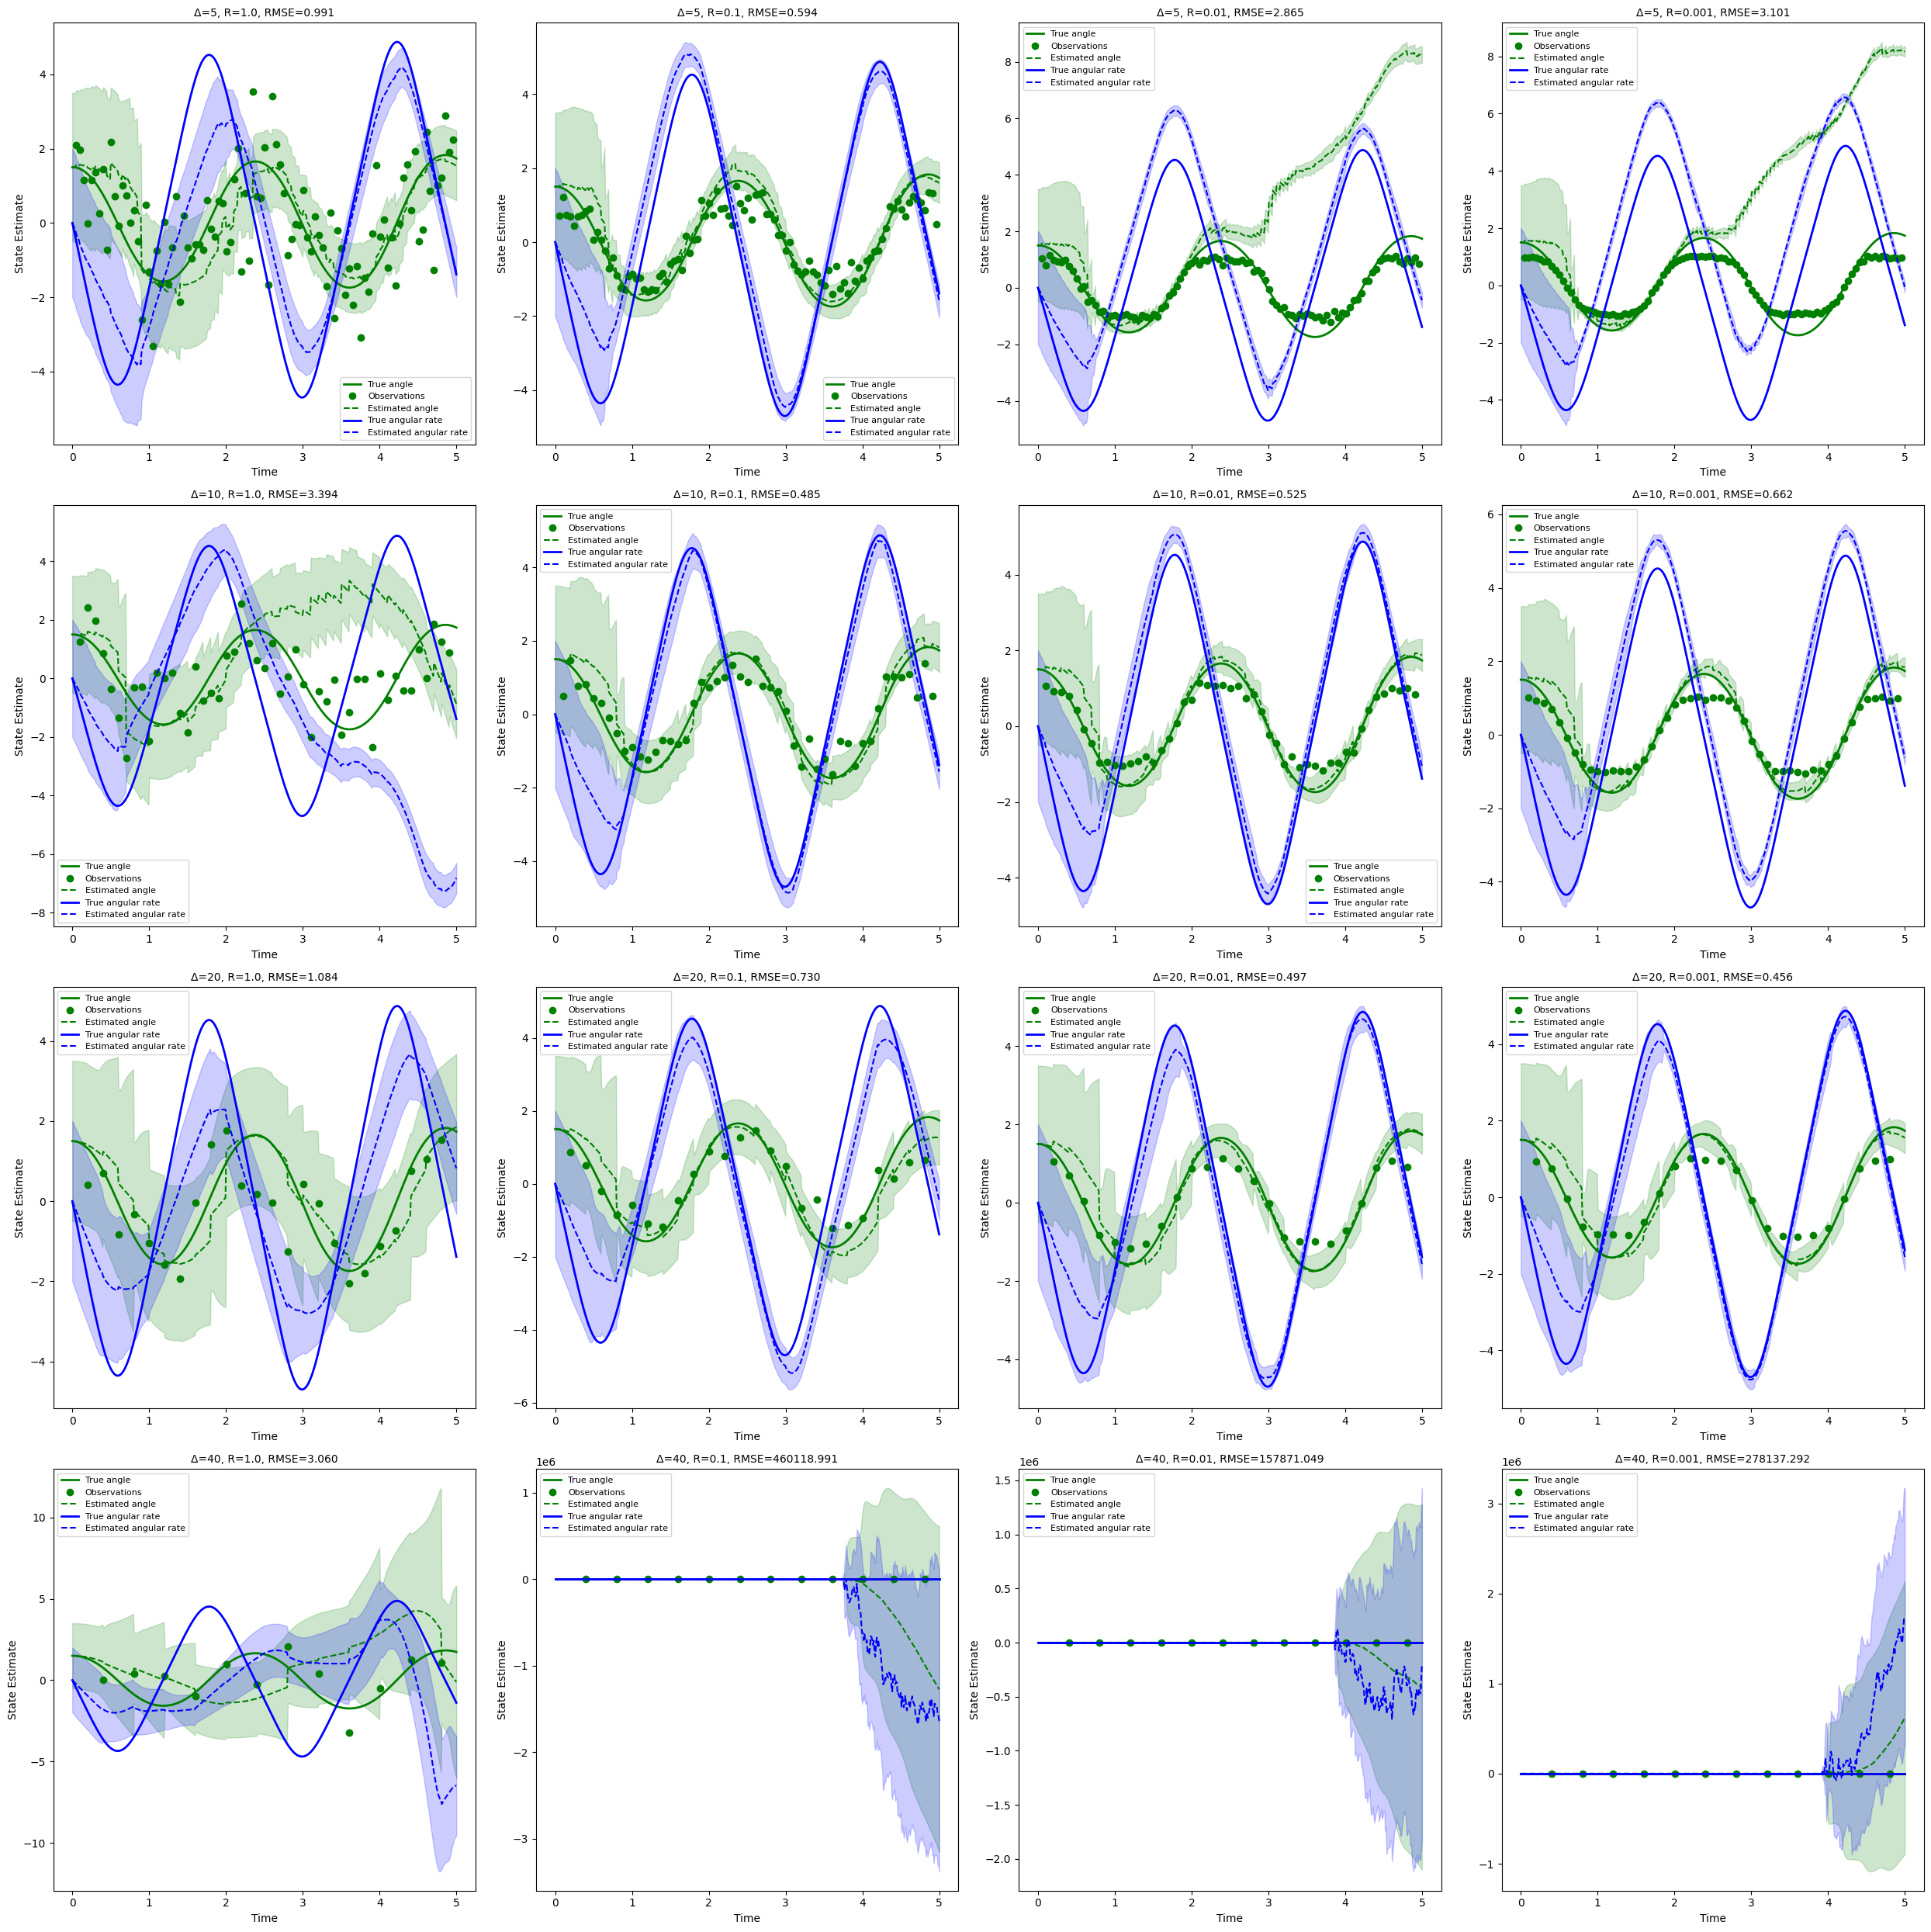

In [7]:
def run_ukf_and_plot(dt, N, x0, q_c, R_values, delta_values, alpha, beta, kappa, save_path):
    """
    Runs the Unscented Kalman Filter (UKF) for multiple values of delta and R, 
    and plots the results in a 4x4 grid.
    
    Parameters:
        dt (float): Time step.
        N (int): Number of time steps.
        x0 (array): Initial state.
        q_c (float): Process noise covariance parameter.
        R_values (array): Array of observation noise covariance values.
        delta_values (array): Array of delta values.
        alpha, beta, kappa: UKF hyperparameters.
        save_path (str): Path to save the output plot.
    """
    def compute_process_noise(q_c, dt):
        """Compute process noise covariance matrix Q."""
        return np.array([[q_c * dt**3 / 3, q_c * dt**2 / 2], 
                         [q_c * dt**2 / 2, q_c * dt]])
    
    def plot_single(ax, true_data, obs_data, kf_results, delta, R):
        """Plots the results for a single subplot."""
        RMSE = np.sqrt(np.mean((kf_results.means - true_data.obs) ** 2))

        # Plot angle
        ax.plot(true_data.times, true_data.obs[:, 0], 'g-', label='True angle', linewidth=2)
        ax.plot(obs_data.times[obs_data.obs_ind], obs_data.obs, 'go', label='Observations')
        ax.plot(true_data.times, kf_results.means[:, 0], 'g--', label='Estimated angle')
        ax.fill_between(true_data.times,
                        kf_results.means[:, 0] - 2 * kf_results.stds[:, 0],
                        kf_results.means[:, 0] + 2 * kf_results.stds[:, 0],
                        color='g', alpha=0.2)

        # Plot angular rate
        ax.plot(true_data.times, true_data.obs[:, 1], 'b-', label='True angular rate', linewidth=2)
        ax.plot(true_data.times, kf_results.means[:, 1], 'b--', label='Estimated angular rate')
        ax.fill_between(true_data.times,
                        kf_results.means[:, 1] - 2 * kf_results.stds[:, 1],
                        kf_results.means[:, 1] + 2 * kf_results.stds[:, 1],
                        color='b', alpha=0.2)

        # Configure plot
        ax.set_title(f"Δ={delta}, R={R}, RMSE={RMSE:.3f}", fontsize=10)
        ax.set_xlabel('Time')
        ax.set_ylabel('State Estimate')
        ax.legend(fontsize=8)

    # Main logic
    Tf = N * dt
    times = np.linspace(0, Tf, N)
    Q = compute_process_noise(q_c, dt)
    X = Gaussian(x0, np.eye(2))

    fig, axs = plt.subplots(4, 4, figsize=(25, 25))
    axs = axs.ravel()

    idx = 0
    for delta in delta_values:
        for R in R_values:
            # Generate data
            true_data, obs_data = generate_data(times, N, dt, delta, x0, R)

            # Set up UKF parameters
            xi = Gaussian(np.zeros(2), Q)
            eta = Gaussian(0, R)

            # Run UKF
            kf_results = unscented_kalman_filter(obs_data, X, xi, eta, alpha, beta, kappa)

            # Plot results
            plot_single(axs[idx], true_data, obs_data, kf_results, delta, R)
            idx += 1

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Parameters
dt = 0.01
N = 500
x0 = np.array([1.5, 0])
q_c = 0.1

# UKF parameters
alpha = 1e-3
beta = 2.2
kappa = 0.22

# Observation and delta values
R_values = np.array([1, 0.1, 0.01, 0.001])
delta_values = np.array([5, 10, 20, 40])

# Run and save plot
run_ukf_and_plot(dt, N, x0, q_c, R_values, delta_values, alpha, beta, kappa, 'ukf_results.png')